<a href="https://colab.research.google.com/github/Masciel-Sevilla/modelos/blob/main/Visualizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🌱 Script de Predicción y Visualización de Malezas 🌱
📁 Archivo encontrado: efficient_weed_model_B0_best.keras

Cargando modelo...
Intentando método 1: Carga con objetos personalizados...
❌ Método 1 falló: Input 0 of layer "conv2d_transpose_20" is incompatible with the layer: expected axis -1 of input shape to have value 192, but received input with shape (None, 4, 4, 960)
Intentando método 2: Carga sin compilar...
❌ Método 2 falló: Input 0 of layer "conv2d_transpose_20" is incompatible with the layer: expected axis -1 of input shape to have value 192, but received input with shape (None, 4, 4, 960)
Intentando método 3: Recrear modelo y cargar pesos...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Método 3a: Pesos cargados directamente

✅ Modelo cargado correctamente!
📊 Arquitectura del modelo: EfficientWeedDetectionModel_B0

Mostrando leyenda de colores...


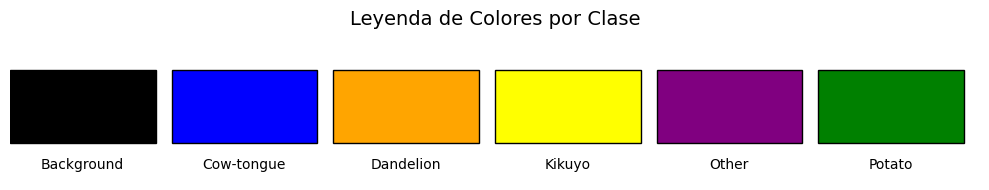

📁 Se encontraron 210 imágenes de test

🔍 Procesando imagen 1/5...


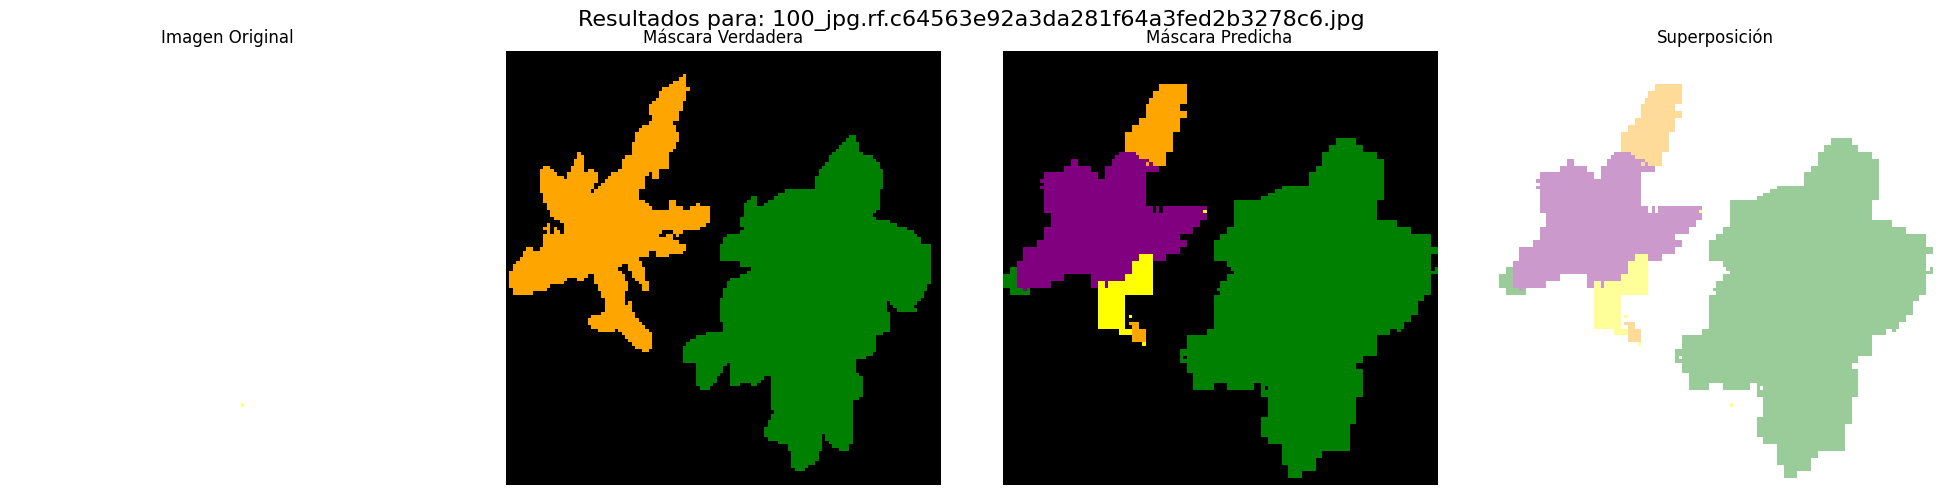


🔍 Procesando imagen 2/5...


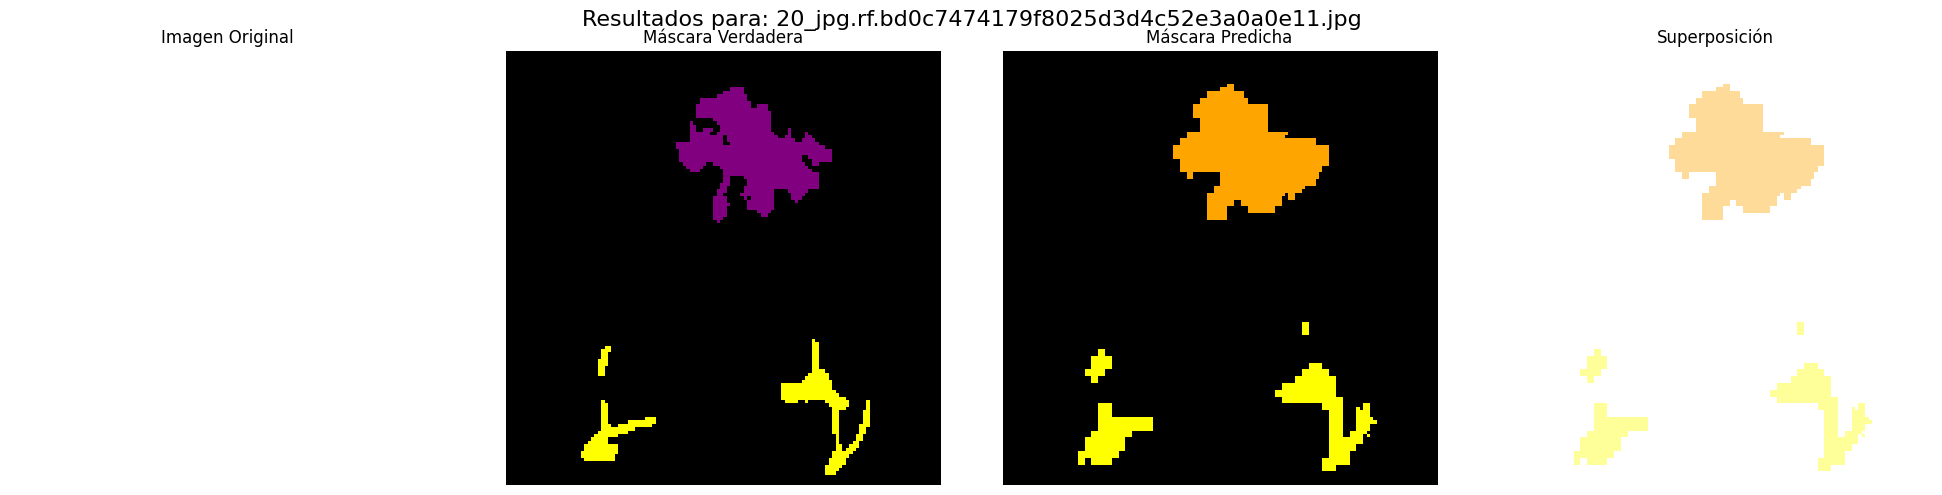


🔍 Procesando imagen 3/5...


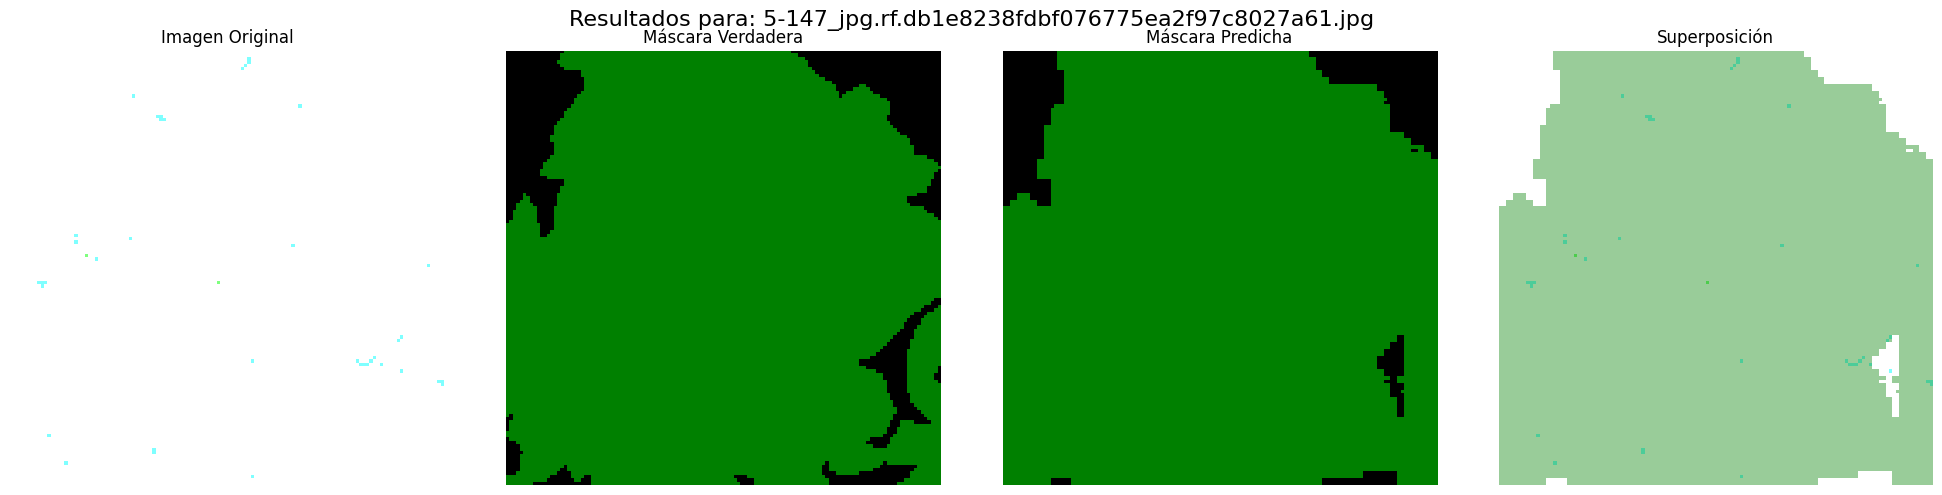


🔍 Procesando imagen 4/5...


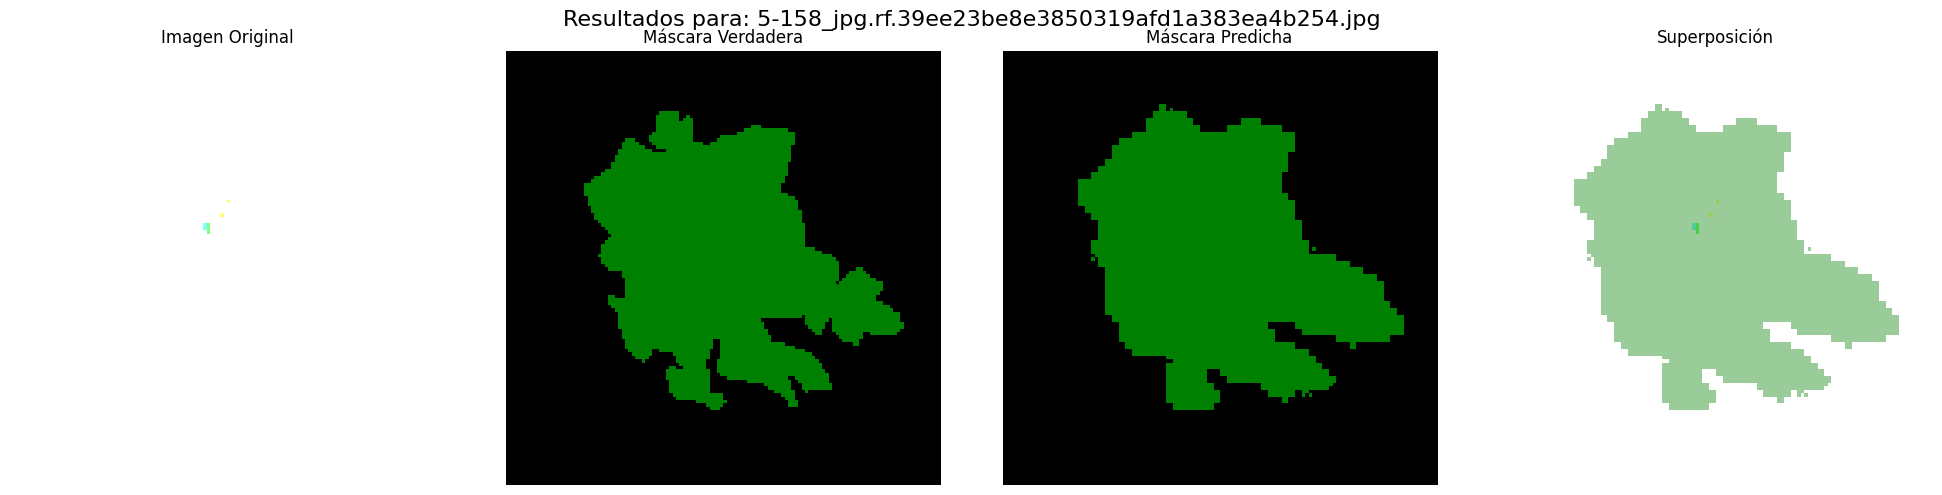


🔍 Procesando imagen 5/5...


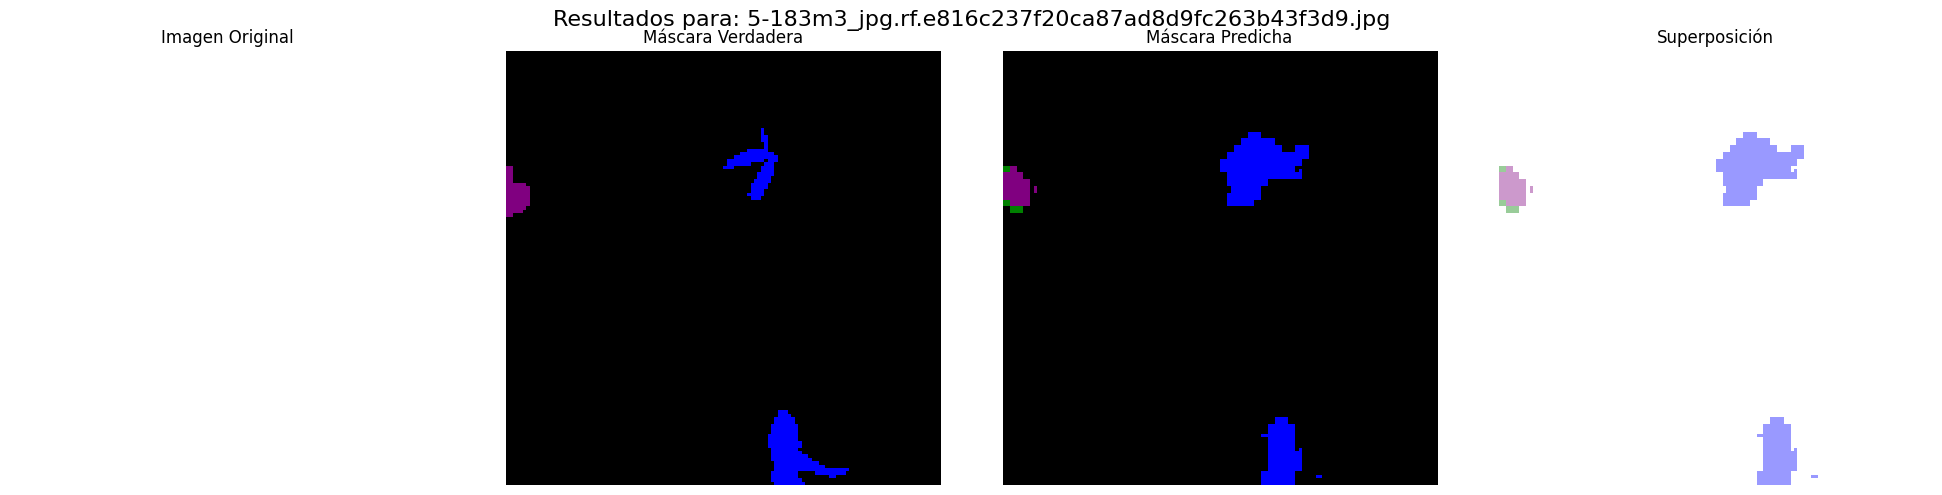


¿Deseas hacer predicción en una imagen específica?
Ingresa la ruta completa de la imagen o presiona Enter para salir:


KeyboardInterrupt: Interrupted by user

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image

# Configuración del modelo (debe coincidir con el entrenamiento)
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6
BATCH_SIZE = 16

# Paths
BASE_PATH = './Balanced'
TEST_IMAGES_PATH = os.path.join(BASE_PATH, 'test/images')
TEST_MASKS_PATH = os.path.join(BASE_PATH, 'test/masks')

# Definir las clases personalizadas (copiadas del script de entrenamiento)
class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)

    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# Funciones de pérdida y métricas (copiadas del script de entrenamiento)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    dice_scores = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return tf.reduce_mean(dice_scores)

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return loss
    return focal_loss_fixed

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    class_weights = tf.constant([0.4, 4.0, 3.5, 1.0, 2.0, 4.0])
    f_loss_per_pixel_per_class = focal_loss(gamma=2.0, alpha=0.75)(y_true, y_pred)
    weighted_f_loss = f_loss_per_pixel_per_class * class_weights
    f_loss_reduced = tf.reduce_sum(weighted_f_loss, axis=-1)
    f_loss_mean = tf.reduce_mean(f_loss_reduced)
    d_loss = dice_loss(y_true, y_pred)
    return (0.6 * f_loss_mean) + (0.4 * d_loss)

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=NUM_CLASSES)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.where(tf.equal(union, 0), 1.0, intersection / union)
    return tf.reduce_mean(iou)

# Diccionario de colores para cada clase
colores_clases = {
    0: [0, 0, 0],       # Background - Negro
    1: [0, 0, 255],     # Cow-tongue - Azul
    2: [255, 165, 0],   # Dandelion - Naranja
    3: [255, 255, 0],   # Kikuyo - Amarillo
    4: [128, 0, 128],   # Other - Morado
    5: [0, 128, 0],     # Potato - Verde
}

def convertir_mascara_a_rgb(mask, colores):
    """Convierte una máscara de clases a imagen RGB."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for clase, color in colores.items():
        rgb[mask == clase] = color
    return rgb

def cargar_imagen(image_path):
    """Carga y preprocesa una imagen individual."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image

def cargar_mascara_verdadera(mask_path):
    """Carga una máscara verdadera (ground truth)."""
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)
    return mask

def predecir_imagen_individual(model, image_path):
    """Hace predicción en una imagen individual."""
    # Cargar y preprocesar imagen
    image = cargar_imagen(image_path)
    image_batch = tf.expand_dims(image, 0)

    # Realizar predicción
    prediction = model.predict(image_batch, verbose=0)
    predicted_mask = tf.argmax(prediction[0], axis=-1).numpy()

    return image, predicted_mask

def visualizar_resultados(image_original, mask_verdadera, mask_predicha, titulo="Comparación"):
    """Visualiza la imagen original, máscara verdadera y máscara predicha."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Imagen original (desnormalizar para visualización)
    image_display = image_original.numpy()
    # Revertir la normalización de EfficientNet
    image_display = image_display + 1.0
    image_display = image_display * 127.5
    image_display = np.clip(image_display, 0, 255).astype(np.uint8)

    axes[0].imshow(image_display)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    # Máscara verdadera
    if mask_verdadera is not None:
        mask_rgb_verdadera = convertir_mascara_a_rgb(mask_verdadera.numpy(), colores_clases)
        axes[1].imshow(mask_rgb_verdadera)
        axes[1].set_title("Máscara Verdadera")
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No disponible', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title("Máscara Verdadera")
        axes[1].axis('off')

    # Máscara predicha
    mask_rgb_predicha = convertir_mascara_a_rgb(mask_predicha, colores_clases)
    axes[2].imshow(mask_rgb_predicha)
    axes[2].set_title("Máscara Predicha")
    axes[2].axis('off')

    # Superposición
    alpha = 0.6
    overlay = image_display.copy()
    mask_rgb_predicha_overlay = mask_rgb_predicha.copy()
    # Solo aplicar overlay donde hay predicción (no background)
    non_background = mask_predicha > 0
    overlay[non_background] = (alpha * overlay[non_background] +
                              (1-alpha) * mask_rgb_predicha_overlay[non_background]).astype(np.uint8)

    axes[3].imshow(overlay)
    axes[3].set_title("Superposición")
    axes[3].axis('off')

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

def crear_leyenda_colores():
    """Crea una leyenda con los colores de cada clase."""
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 2)

    class_names = ['Background', 'Cow-tongue', 'Dandelion', 'Kikuyo', 'Other', 'Potato']

    for i, (clase, color) in enumerate(colores_clases.items()):
        # Normalizar colores para matplotlib (0-1)
        color_norm = [c/255.0 for c in color]
        ax.add_patch(plt.Rectangle((i*2, 0.5), 1.8, 1, facecolor=color_norm, edgecolor='black'))
        ax.text(i*2 + 0.9, 0.2, class_names[clase], ha='center', va='center', fontsize=10, rotation=0)

    ax.set_title("Leyenda de Colores por Clase", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def buscar_archivo_modelo():
    """Busca el archivo del modelo en diferentes formatos y ubicaciones."""
    posibles_rutas = [
        'efficient_weed_model_B0_best.keras',
        'efficient_weed_model_B0.keras',
        'efficient_weed_model_B0_best.h5',
        'efficient_weed_model_B0.h5',
        './efficient_weed_model_B0_best.keras',
        './efficient_weed_model_B0.keras'
    ]

    for ruta in posibles_rutas:
        if os.path.exists(ruta):
            print(f"📁 Archivo encontrado: {ruta}")
            return ruta

    print("❌ No se encontró el archivo del modelo en las ubicaciones esperadas:")
    for ruta in posibles_rutas:
        print(f"  - {ruta}")

    # Permitir al usuario especificar la ruta manualmente
    ruta_manual = input("\n🔍 Por favor, ingresa la ruta completa al archivo del modelo: ").strip()
    if ruta_manual and os.path.exists(ruta_manual):
        return ruta_manual

    return None

def crear_modelo_para_prediccion():
    """Crea el modelo de predicción."""
    def create_efficient_backbone(input_shape):
        base_model = tf.keras.applications.EfficientNetV2B0(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False
        )
        base_model.trainable = True
        layer_names = [
            'block1a_project_activation',
            'block2b_add',
            'block3b_add',
            'block5c_add',
            'top_activation'
        ]
        outputs = [base_model.get_layer(name).output for name in layer_names]
        return Model(inputs=base_model.input, outputs=outputs, name='EfficientNetV2B0_Backbone')

    def create_weed_detection_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
        inputs = layers.Input(shape=input_shape)
        backbone = create_efficient_backbone(input_shape)
        feat1_out, feat2_out, feat3_out, feat4_out, feat5_out = backbone(inputs)

        deep_features = feat5_out
        aspp_filters = 192
        aspp_features = ASPPModule(filters=aspp_filters)(deep_features)
        attended_features = DeformableAttention(filters=aspp_filters)(aspp_features)

        # Decoder
        decoder_up1 = layers.Conv2DTranspose(96, 2, strides=2, padding='same', use_bias=False)(attended_features)
        decoder_up1 = layers.BatchNormalization()(decoder_up1)
        decoder_up1 = layers.ReLU()(decoder_up1)
        decoder_up1 = layers.Dropout(0.2)(decoder_up1)

        feat4_processed = layers.Conv2D(96, 1, padding='same', use_bias=False)(feat4_out)
        feat4_processed = layers.BatchNormalization()(feat4_processed)
        feat4_processed = layers.ReLU()(feat4_processed)

        decoder_concat_8x8 = layers.Concatenate()([decoder_up1, feat4_processed])
        decoder_conv_8x8 = layers.SeparableConv2D(96, 3, padding='same', use_bias=False)(decoder_concat_8x8)
        decoder_conv_8x8 = layers.BatchNormalization()(decoder_conv_8x8)
        decoder_conv_8x8 = layers.ReLU()(decoder_conv_8x8)
        decoder_conv_8x8 = layers.Dropout(0.2)(decoder_conv_8x8)

        decoder_up2 = layers.Conv2DTranspose(96, 2, strides=2, padding='same', use_bias=False)(decoder_conv_8x8)
        decoder_up2 = layers.BatchNormalization()(decoder_up2)
        decoder_up2 = layers.ReLU()(decoder_up2)
        decoder_up2 = layers.Dropout(0.2)(decoder_up2)

        feat3_processed = layers.Conv2D(96, 1, padding='same', use_bias=False)(feat3_out)
        feat3_processed = layers.BatchNormalization()(feat3_processed)
        feat3_processed = layers.ReLU()(feat3_processed)

        decoder_concat_16x16 = layers.Concatenate()([decoder_up2, feat3_processed])
        decoder_conv_16x16 = layers.SeparableConv2D(96, 3, padding='same', use_bias=False)(decoder_concat_16x16)
        decoder_conv_16x16 = layers.BatchNormalization()(decoder_conv_16x16)
        decoder_conv_16x16 = layers.ReLU()(decoder_conv_16x16)
        decoder_conv_16x16 = layers.Dropout(0.2)(decoder_conv_16x16)

        decoder_up3 = layers.Conv2DTranspose(48, 2, strides=2, padding='same', use_bias=False)(decoder_conv_16x16)
        decoder_up3 = layers.BatchNormalization()(decoder_up3)
        decoder_up3 = layers.ReLU()(decoder_up3)
        decoder_up3 = layers.Dropout(0.2)(decoder_up3)

        feat2_processed = layers.Conv2D(48, 1, padding='same', use_bias=False)(feat2_out)
        feat2_processed = layers.BatchNormalization()(feat2_processed)
        feat2_processed = layers.ReLU()(feat2_processed)

        decoder_concat_32x32 = layers.Concatenate()([decoder_up3, feat2_processed])
        decoder_conv_32x32 = layers.SeparableConv2D(48, 3, padding='same', use_bias=False)(decoder_concat_32x32)
        decoder_conv_32x32 = layers.BatchNormalization()(decoder_conv_32x32)
        decoder_conv_32x32 = layers.ReLU()(decoder_conv_32x32)
        decoder_conv_32x32 = layers.Dropout(0.2)(decoder_conv_32x32)

        decoder_up4 = layers.Conv2DTranspose(24, 2, strides=2, padding='same', use_bias=False)(decoder_conv_32x32)
        decoder_up4 = layers.BatchNormalization()(decoder_up4)
        decoder_up4 = layers.ReLU()(decoder_up4)
        decoder_up4 = layers.Dropout(0.2)(decoder_up4)

        feat1_processed = layers.Conv2D(24, 1, padding='same', use_bias=False)(feat1_out)
        feat1_processed = layers.BatchNormalization()(feat1_processed)
        feat1_processed = layers.ReLU()(feat1_processed)

        decoder_concat_64x64 = layers.Concatenate()([decoder_up4, feat1_processed])
        decoder_conv_64x64 = layers.SeparableConv2D(24, 3, padding='same', use_bias=False)(decoder_concat_64x64)
        decoder_conv_64x64 = layers.BatchNormalization()(decoder_conv_64x64)
        decoder_conv_64x64 = layers.ReLU()(decoder_conv_64x64)
        decoder_conv_64x64 = layers.Dropout(0.2)(decoder_conv_64x64)

        outputs = layers.Conv2DTranspose(NUM_CLASSES, 2, strides=2, padding='same', use_bias=False)(decoder_conv_64x64)
        outputs = layers.Conv2D(NUM_CLASSES, 1, padding='same', activation='softmax', name='segmentation_output')(outputs)

        model = Model(inputs=inputs, outputs=outputs, name='EfficientWeedDetectionModel_B0')
        return model

    return create_weed_detection_model()

def main():
    print("🌱 Script de Predicción y Visualización de Malezas 🌱")
    print("="*60)

    # Buscar el archivo del modelo
    model_path = buscar_archivo_modelo()
    if not model_path:
        print("❌ No se pudo encontrar el archivo del modelo.")
        return

    print("\nCargando modelo...")
    model = None

    # Método 1: Carga estándar con objetos personalizados
    try:
        print("Intentando método 1: Carga con objetos personalizados...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'ASPPModule': ASPPModule,
                'DeformableAttention': DeformableAttention,
                'combined_loss': combined_loss,
                'dice_coefficient': dice_coefficient,
                'iou_metric': iou_metric,
                'dice_loss': dice_loss
            }
        )
        print("✅ Método 1: Modelo cargado exitosamente")
    except Exception as e1:
        print(f"❌ Método 1 falló: {str(e1)}")

        # Método 2: Carga sin compilar
        try:
            print("Intentando método 2: Carga sin compilar...")
            model = tf.keras.models.load_model(
                model_path,
                custom_objects={
                    'ASPPModule': ASPPModule,
                    'DeformableAttention': DeformableAttention,
                },
                compile=False
            )
            print("✅ Método 2: Modelo cargado exitosamente (sin compilar)")

        except Exception as e2:
            print(f"❌ Método 2 falló: {str(e2)}")

            # Método 3: Recrear el modelo y cargar pesos
            try:
                print("Intentando método 3: Recrear modelo y cargar pesos...")
                model = crear_modelo_para_prediccion()

                # Intentar diferentes métodos de carga de pesos
                try:
                    # Método 3a: Cargar pesos directamente
                    model.load_weights(model_path)
                    print("✅ Método 3a: Pesos cargados directamente")
                except:
                    try:
                        # Método 3b: Cargar desde modelo temporal
                        temp_model = tf.keras.models.load_model(
                            model_path,
                            custom_objects={
                                'ASPPModule': ASPPModule,
                                'DeformableAttention': DeformableAttention,
                            },
                            compile=False
                        )
                        model.set_weights(temp_model.get_weights())
                        del temp_model
                        print("✅ Método 3b: Pesos transferidos desde modelo temporal")
                    except Exception as e3b:
                        raise e3b

            except Exception as e3:
                print(f"❌ Método 3 falló: {str(e3)}")
                print("❌ No se pudo cargar el modelo con ningún método.")
                print("\n💡 Sugerencias:")
                print("1. Verifica que el archivo del modelo exista y no esté corrupto")
                print("2. Asegúrate de que la versión de TensorFlow sea compatible")
                print("3. Considera volver a entrenar el modelo si persiste el problema")
                return

    if model is None:
        print("❌ No se pudo cargar el modelo.")
        return

    print("\n✅ Modelo cargado correctamente!")
    print(f"📊 Arquitectura del modelo: {model.name}")

    # Mostrar leyenda de colores
    print("\nMostrando leyenda de colores...")
    crear_leyenda_colores()

    # Obtener rutas de imágenes de test
    test_image_paths = sorted(glob(os.path.join(TEST_IMAGES_PATH, '*.jpg')))
    test_mask_paths = sorted(glob(os.path.join(TEST_MASKS_PATH, '*.png')))

    if not test_image_paths:
        print(f"❌ No se encontraron imágenes en {TEST_IMAGES_PATH}")
        print("Por favor, verifica la ruta del dataset.")
        return

    print(f"📁 Se encontraron {len(test_image_paths)} imágenes de test")

    # Predecir en las primeras 5 imágenes (o las que estén disponibles)
    num_ejemplos = min(5, len(test_image_paths))

    for i in range(num_ejemplos):
        print(f"\n🔍 Procesando imagen {i+1}/{num_ejemplos}...")

        image_path = test_image_paths[i]
        mask_path = test_mask_paths[i] if i < len(test_mask_paths) else None

        try:
            # Cargar imagen original y hacer predicción
            image_original, mask_predicha = predecir_imagen_individual(model, image_path)

            # Cargar máscara verdadera si existe
            mask_verdadera = None
            if mask_path and os.path.exists(mask_path):
                mask_verdadera = cargar_mascara_verdadera(mask_path)

            # Visualizar resultados
            nombre_archivo = os.path.basename(image_path)
            titulo = f"Resultados para: {nombre_archivo}"
            visualizar_resultados(image_original, mask_verdadera, mask_predicha, titulo)

        except Exception as e:
            print(f"❌ Error procesando {os.path.basename(image_path)}: {str(e)}")

    # Opción para predecir en una imagen específica
    print("\n" + "="*60)
    print("¿Deseas hacer predicción en una imagen específica?")
    print("Ingresa la ruta completa de la imagen o presiona Enter para salir:")

    while True:
        ruta_imagen = input("\nRuta de imagen: ").strip()

        if not ruta_imagen:
            print("👋 ¡Gracias por usar el script de predicción!")
            break

        if not os.path.exists(ruta_imagen):
            print("❌ La imagen no existe. Intenta de nuevo.")
            continue

        try:
            print("🔍 Procesando imagen personalizada...")
            image_original, mask_predicha = predecir_imagen_individual(model, ruta_imagen)

            # Buscar máscara correspondiente (opcional)
            nombre_base = os.path.splitext(os.path.basename(ruta_imagen))[0]
            posible_mask_path = os.path.join(os.path.dirname(ruta_imagen), '..', 'masks', nombre_base + '.png')

            mask_verdadera = None
            if os.path.exists(posible_mask_path):
                mask_verdadera = cargar_mascara_verdadera(posible_mask_path)
                print("✅ Se encontró máscara correspondiente")
            else:
                print("⚠️ No se encontró máscara correspondiente")

            titulo = f"Predicción para: {os.path.basename(ruta_imagen)}"
            visualizar_resultados(image_original, mask_verdadera, mask_predicha, titulo)

        except Exception as e:
            print(f"❌ Error al procesar la imagen: {str(e)}")

        print("\n¿Otra imagen? (Enter para salir)")

if __name__ == "__main__":
    main()

In [2]:
# Paso 1: Descomprimir el dataset (esto solo se hace una vez)
import os
import zipfile

zip_path = '/content/Balanced.zip'
extract_path = '/content/'

# Solo descomprimir si no se ha hecho antes
if not os.path.exists(os.path.join(extract_path, 'Balanced')):
    print(f"Descomprimiendo {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("¡Descompresión completada!")
else:
    print("La carpeta 'Balanced' ya existe. Omitiendo descompresión.")

Descomprimiendo /content/Balanced.zip...
¡Descompresión completada!
